# Steam Library Analyzer
## GitHub repository: [https://github.com/saulTejeda117/Steam-Data-Analyzer](https://github.com/saulTejeda117/Steam-Data-Analyzer)

Steam Library Analyzer es un projecto de ciencia de datos enfocado principalmente en el analisis predictivo de los habitos de juego de los usuarios de [_`Steam`_](https://store.steampowered.com). Su objetivo principal es determinar el tiempo estimado para completar todos los juegos de la biblioteca de un jugador. Para ello se ha hecho uso de fuentes de información tales como la WEB dedicada a videojuegos [_`How Long To Beat`_](https://howlongtobeat.com) y la [_`Steam API`_](https://steamcommunity.com/dev) que hacen posible acceder a información necesaria como:

- **Completion Rate:** Es la métrica que indica la proporción de juegos que un jugador ha completado en comparación con el total de juegos en su biblioteca.
  
- **Total games:** Hace referencia a la cantidad total de juegos que un usuario tiene actualmente en su biblioteca de juegos de Steam.
  
- **Perfect Games:** Se refiere aquellosjuegos cuyas metas y logros han sido alcanzados al 100%, según las estadísticas proporcionadas por Steam.

<img src="SteamAnalyzerCover2.jpg">


</img>

<hr>

In [1]:
import requests
import json
import time
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns



from tqdm import tqdm


## Obtain User Steam Profile Data

El proceso de análisis se inicia mediante la obtención de la información esencial de la cuenta de usuario que se pretende evaluar. En este sentido, se procede a extraer los datos pertinentes del archivo _JSON_ denominado  _`"steam_credentials.json"`_, dicho archivo alberga información crucial, incluyendo:

- **Steam API key:** son identificadores únicos e irrepetibles proporcionados por Steam a desarrolladores y aplicaciones que desean acceder a la Steam API.
  
- **Steam ID:** se refiere a un identificador único utilizado para identificar de manera única a los usuarios y sus perfiles en la plataforma Steam.

In [2]:
# Load the steam credentials JSON file 
with open('steam_credentials.json') as json_file:
    credentials = json.load(json_file)

api_key = credentials.get('api_key')
#steam_id = credentials.get('steam_id')

steam_id = "76561198142358795"

Posteriormente se realiza una consulta a la [_`Steam API`_](https://steamcommunity.com/dev) para obtener los datos de la cuenta de usuario al que pertecenen las credenciales ingresadas. Se comprueba la  respuesta de la petición.


In [3]:
# Obtener la URL de la información del jugador utilizando la API de Steam
player_info_url = f'http://api.steampowered.com/ISteamUser/GetPlayerSummaries/v0002/?key={api_key}&steamids={steam_id}'
response = requests.get(player_info_url)

if (response != None):
    data = response.json()
    # print(data, "\n\n\n")
    print("Username: ", data['response']['players'][0]['personaname'])
    print("Avatar: ", data['response']['players'][0]['avatarfull'])
    print("Link: ", data['response']['players'][0]['profileurl'])

else:
    print("Something  went wrong!")


Username:  Abadon
Avatar:  https://avatars.steamstatic.com/2488f0c70ca5b66019da25ec51a122e62d8c7d45_full.jpg
Link:  https://steamcommunity.com/id/Abadon/


<hr>

## Obtain User Steam Library Data

Después de obtener los datos del usuario de la cuenta de Steam procedemos a obtener los datos de juego de su biblioteca, de los datos principales que nos interesan obtener en esta parte del proceso destacan principalmente
  
- **steam_id:** se refiere a un identificador único utilizado para identificar de manera única a los usuarios y sus perfiles en la plataforma Steam.

- **appid:** son identificadores únicos e irrepetibles proporcionados por Steam a desarrolladores y aplicaciones que desean acceder a la Steam API.
  
- **playtime_forever:** se refiere a un identificador único utilizado para identificar de manera única a los usuarios y sus perfiles en la plataforma Steam.

- **total_playtime:** hace referencia al tiempo total de juego acumulado por un usuario en todos los juegos de su biblioteca de Steam. Este dato puede ser esencial para comprender la dedicación y el nivel de participación de un jugador en su colección de juegos.


### Obtain AppID and Playtime Data

In [4]:
# Get data from my Steam library
games_endpoint = f"https://api.steampowered.com/IPlayerService/GetOwnedGames/v1/?key={api_key}&include_appinfo=1&steamid={steam_id}"

response_games = requests.get(games_endpoint)
data_games = response_games.json()
df_games = pd.json_normalize(data_games['response']['games'])

df_games['achievement_percentage'] = None
df_games['achievement_completed'] = None
df_games['total_achievements'] = None
df_games['beat_time'] = None
df_games

,appid,name,playtime_forever,img_icon_url,has_community_visible_stats,content_descriptorids,has_leaderboards,playtime_2weeks,achievement_percentage,achievement_completed,total_achievements,beat_time
0,300,Day of Defeat: Source,1917,062754bb5853b0534283ae27dc5d58200692b22d,True,NaN,NaN,NaN,None,None,None,None
1,20,Team Fortress Classic,1,38ea7ebe3c1abbbbf4eabdbef174c41a972102b9,NaN,"[2, 5]",NaN,NaN,None,None,None,None
2,30,Day of Defeat,0,aadc0ce51ff6ba2042d633f8ec033b0de62091d0,NaN,NaN,NaN,NaN,None,None,None,None
3,40,Deathmatch Classic,0,c525f76c8bc7353db4fd74b128c4ae2028426c2a,NaN,NaN,NaN,NaN,None,None,None,None
4,50,Half-Life: Opposing Force,0,04e81206c10e12416908c72c5f22aad411b3aeef,NaN,NaN,NaN,NaN,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
9492,2478970,Tomb Raider I-III Remastered Starring Lara Croft,0,7bd910d66157ffcadd96bcd9333dd45f318e5c58,True,"[2, 5]",NaN,NaN,None,None,None,None
9493,1086940,Baldur's Gate 3,0,d866cae7ea1e471fdbc206287111f1b642373bd9,True,"[1, 2, 5]",NaN,NaN,None,None,None,None
9494,344740,CRYPTARK,0,c56bc2236cbcee87cab5c3d99e97be9f24d8cf50,True,NaN,True,NaN,None,None,None,None
9495,577940,Killer Instinct,0,10c39134ff17a0af1bba131a6036362606785167,True,NaN,NaN,NaN,None,None,None,None


### Obtain Games' names

Este paso es sumamente importante para el proceso de extracción de los datos, debido a que las fuentes de información de las cuales se extrae la información son diferentes y no es posible acceder a los datos de los juegos en [_`How Long To Beat`_](https://howlongtobeat.com) únicamente con el AppID de [_`Steam API`_](https://steamcommunity.com/dev), por lo que es necesario extraer el nombre de los juegos.

In [5]:
total_playtime  = df_games['playtime_forever'].sum()

indice_max_playtime = df_games['playtime_forever'].idxmax()
favorite_game_appid = df_games.loc[indice_max_playtime, 'name']

print("Total playtime: ",total_playtime, "minutes")
print("Favorite Game: ", df_games.loc[indice_max_playtime,'name'], df_games.loc[indice_max_playtime,'playtime_forever'] )

Total playtime:  6407347 minutes
Favorite Game:  Sea of Thieves 396772


### Obtain games archivements information


- **achievement_completion:** eEnestel contexto "achievement_progress" se refiere al progreso que un jugador ha alcanzado en desbloquear o completar logros dentro de un juego.

- **achv_percentage** se refiere al porcentaje de logros o hitos que un jugador ha desbloqueado o completado en un juego en comparación con el total de logros disponibles

- **achievement_completed:**

- **total_games:**.


In [6]:
total_games = 0
for game in tqdm(range(len(df_games)), desc="Processing Games"):
    appid = df_games.iloc[game]['appid']
    url_achievements = f'http://api.steampowered.com/ISteamUserStats/GetPlayerAchievements/v0001/?key={api_key}&steamid={steam_id}&appid={appid}'
    response = requests.get(url_achievements)
    data_achievements = response.json()

    if(data_achievements['playerstats']['success'] != False):

        try:
            total_achievements = len(data_achievements['playerstats']['achievements'])
            num_achievements_1 = sum(1 for achievement in data_achievements['playerstats']['achievements'] if achievement['achieved'] == 1)
            num_achievements_0 = sum(1 for achievement in data_achievements['playerstats']['achievements'] if achievement['achieved'] == 0)

            achievement_percentage = (num_achievements_1*100)/total_achievements

            total_games += 1

            df_games.loc[game, 'total_achievements'] = total_achievements
            df_games.loc[game, 'achievement_completed'] = num_achievements_1
            df_games.loc[game, 'achievement_percentage'] = achievement_percentage
            
        except:
            pass
        
print("\n**********PROCESO TERMINADO************\n")


Processing Games: 100%|████████████████████████████████████████████████████████████| 9497/9497 [43:33<00:00,  3.63it/s]


**********PROCESO TERMINADO************



In [7]:
print("Total Games with Archivements:", total_games)
df_games

Total Games with Archivements: 5483


,appid,name,playtime_forever,img_icon_url,has_community_visible_stats,content_descriptorids,has_leaderboards,playtime_2weeks,achievement_percentage,achievement_completed,total_achievements,beat_time
0,300,Day of Defeat: Source,1917,062754bb5853b0534283ae27dc5d58200692b22d,True,NaN,NaN,NaN,0.0,0,54,None
1,20,Team Fortress Classic,1,38ea7ebe3c1abbbbf4eabdbef174c41a972102b9,NaN,"[2, 5]",NaN,NaN,None,None,None,None
2,30,Day of Defeat,0,aadc0ce51ff6ba2042d633f8ec033b0de62091d0,NaN,NaN,NaN,NaN,None,None,None,None
3,40,Deathmatch Classic,0,c525f76c8bc7353db4fd74b128c4ae2028426c2a,NaN,NaN,NaN,NaN,None,None,None,None
4,50,Half-Life: Opposing Force,0,04e81206c10e12416908c72c5f22aad411b3aeef,NaN,NaN,NaN,NaN,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
9492,2478970,Tomb Raider I-III Remastered Starring Lara Croft,0,7bd910d66157ffcadd96bcd9333dd45f318e5c58,True,"[2, 5]",NaN,NaN,0.0,0,269,None
9493,1086940,Baldur's Gate 3,0,d866cae7ea1e471fdbc206287111f1b642373bd9,True,"[1, 2, 5]",NaN,NaN,0.0,0,54,None
9494,344740,CRYPTARK,0,c56bc2236cbcee87cab5c3d99e97be9f24d8cf50,True,NaN,True,NaN,0.0,0,27,None
9495,577940,Killer Instinct,0,10c39134ff17a0af1bba131a6036362606785167,True,NaN,NaN,NaN,0.0,0,463,None


<hr>

## Get data from howlongtobeat

In [8]:
games = 0

for game in tqdm(range(len(df_games)), desc="How long to beat Games"):
    game_name = df_games.iloc[game]['name']

    if(game_name != None):
        game_name1 = re.sub(r'[^a-zA-Z0-9\s\:\.\-\,]', '', game_name)
    
        beat_time_data = f"https://hltb-api.vercel.app/api?name={game_name1}"
        #print(beat_time_data) 
        beat_time_response = requests.get(beat_time_data)
        
        if (beat_time_response.status_code == 200):
            beat_time_data = beat_time_response.json()
            #print(beat_time_data) 
            try:
                if(beat_time_data[0]['gameplayCompletionist'] != 0):
                    
                    df_games.loc[game, 'beat_time'] = (beat_time_data[0]['gameplayCompletionist'])*60

                else:
                    df_games.loc[game, 'beat_time'] = (beat_time_data[0]['gameplayMain'])*60
                    
                games += 1
            except:
                print("ERROR:", game_name1)
               
print("\n**********PROCESO TERMINADO************\n")

ERROR: Feeding Frenzy 2: Shipwreck Showdown Deluxe
ERROR: Dark Messiah of Might  Magic Single Player
ERROR: Dark Messiah of Might  Magic Multi-Player
ERROR: 688I HunterKiller
ERROR: Call of Duty 2003
ERROR: Runaway: The Dream of the Turtle
ERROR: Space Empires IV Deluxe
ERROR: Heretic: Shadow of the Serpent Riders
ERROR: Total War: MEDIEVAL II - Definitive Edition
ERROR: Call of Duty 4: Modern Warfare 2007
ERROR: Shadowgrounds: Survivor
ERROR: Rayman: Raving Rabbids
ERROR: Telltale Texas HoldEm
ERROR: Insecticide Part 1
ERROR: FlatOut: Ultimate Carnage Collectors Edition
ERROR: Mass Effect 2007
ERROR: Dead Space 2008
ERROR: Company of Heroes - Legacy Edition
ERROR: Star Wars: Battlefront 2 Classic, 2005
ERROR: 3D Ultra Minigolf Adventures Deluxe
ERROR: Call of Duty: Modern Warfare 2 2009
ERROR: Call of Duty: Modern Warfare 2 2009 - Multiplayer
ERROR: Mystery PI: The Vegas Heist
ERROR: Serious Sam Fusion 2017 beta
ERROR: 9th Company - Roots of Terror
ERROR: Fallout 3 - Game of the Year 

SSLError: HTTPSConnectionPool(host='hltb-api.vercel.app', port=443): Max retries exceeded with url: /api?name=Star%20Sweet (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1006)')))

In [9]:
df_games.head()

,appid,name,playtime_forever,img_icon_url,has_community_visible_stats,content_descriptorids,has_leaderboards,playtime_2weeks,achievement_percentage,achievement_completed,total_achievements,beat_time
0,300,Day of Defeat: Source,1917,062754bb5853b0534283ae27dc5d58200692b22d,True,NaN,NaN,NaN,0.0,0,54,120
1,20,Team Fortress Classic,1,38ea7ebe3c1abbbbf4eabdbef174c41a972102b9,NaN,"[2, 5]",NaN,NaN,None,None,None,1140
2,30,Day of Defeat,0,aadc0ce51ff6ba2042d633f8ec033b0de62091d0,NaN,NaN,NaN,NaN,None,None,None,5040
3,40,Deathmatch Classic,0,c525f76c8bc7353db4fd74b128c4ae2028426c2a,NaN,NaN,NaN,NaN,None,None,None,720
4,50,Half-Life: Opposing Force,0,04e81206c10e12416908c72c5f22aad411b3aeef,NaN,NaN,NaN,NaN,None,None,None,420


In [ ]:
#df_games.to_csv("df_games.csv") 

<hr>

## Dataset Analysis

In [10]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9497 entries, 0 to 9496
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   appid                        9497 non-null   int64  
 1   name                         9497 non-null   object 
 2   playtime_forever             9497 non-null   int64  
 3   img_icon_url                 9497 non-null   object 
 4   has_community_visible_stats  5546 non-null   object 
 5   content_descriptorids        1132 non-null   object 
 6   has_leaderboards             844 non-null    object 
 7   playtime_2weeks              3 non-null      float64
 8   achievement_percentage       5483 non-null   object 
 9   achievement_completed        5483 non-null   object 
 10  total_achievements           5483 non-null   object 
 11  beat_time                    5271 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 890.5+ KB


In [11]:
print((df_games.isnull().sum()/(len(df_games)))*100)

appid                           0.000000
name                            0.000000
playtime_forever                0.000000
img_icon_url                    0.000000
has_community_visible_stats    41.602611
content_descriptorids          88.080446
has_leaderboards               91.112983
playtime_2weeks                99.968411
achievement_percentage         42.265979
achievement_completed          42.265979
total_achievements             42.265979
beat_time                      44.498263
dtype: float64


In [12]:
df_games.describe(include='all')

,appid,name,playtime_forever,img_icon_url,has_community_visible_stats,content_descriptorids,has_leaderboards,playtime_2weeks,achievement_percentage,achievement_completed,total_achievements,beat_time
count,9.497000e+03,9497,9497.000000,9497,5546,1132,844,3.000000,5483.0,5483.0,5483.0,5271.0
unique,NaN,9488,NaN,9331,1,9,1,NaN,125.0,197.0,351.0,237.0
top,NaN,Maelstrom,NaN,74698583248254ff59f137a1c19e03b5169b4879,True,"[2, 5]",True,NaN,0.0,0.0,12.0,0.0
freq,NaN,2,NaN,36,5546,428,844,NaN,5149.0,5149.0,208.0,1770.0
mean,6.520148e+05,NaN,674.670633,NaN,NaN,NaN,NaN,633.000000,NaN,NaN,NaN,NaN
std,4.228489e+05,NaN,7173.553971,NaN,NaN,NaN,NaN,1060.994345,NaN,NaN,NaN,NaN
min,1.000000e+01,NaN,0.000000,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN
25%,3.540500e+05,NaN,0.000000,NaN,NaN,NaN,NaN,20.500000,NaN,NaN,NaN,NaN
50%,5.779400e+05,NaN,0.000000,NaN,NaN,NaN,NaN,36.000000,NaN,NaN,NaN,NaN
75%,8.206000e+05,NaN,0.000000,NaN,NaN,NaN,NaN,947.000000,NaN,NaN,NaN,NaN


In [13]:
df_games

,appid,name,playtime_forever,img_icon_url,has_community_visible_stats,content_descriptorids,has_leaderboards,playtime_2weeks,achievement_percentage,achievement_completed,total_achievements,beat_time
0,300,Day of Defeat: Source,1917,062754bb5853b0534283ae27dc5d58200692b22d,True,NaN,NaN,NaN,0.0,0,54,120
1,20,Team Fortress Classic,1,38ea7ebe3c1abbbbf4eabdbef174c41a972102b9,NaN,"[2, 5]",NaN,NaN,None,None,None,1140
2,30,Day of Defeat,0,aadc0ce51ff6ba2042d633f8ec033b0de62091d0,NaN,NaN,NaN,NaN,None,None,None,5040
3,40,Deathmatch Classic,0,c525f76c8bc7353db4fd74b128c4ae2028426c2a,NaN,NaN,NaN,NaN,None,None,None,720
4,50,Half-Life: Opposing Force,0,04e81206c10e12416908c72c5f22aad411b3aeef,NaN,NaN,NaN,NaN,None,None,None,420
...,...,...,...,...,...,...,...,...,...,...,...,...
9492,2478970,Tomb Raider I-III Remastered Starring Lara Croft,0,7bd910d66157ffcadd96bcd9333dd45f318e5c58,True,"[2, 5]",NaN,NaN,0.0,0,269,None
9493,1086940,Baldur's Gate 3,0,d866cae7ea1e471fdbc206287111f1b642373bd9,True,"[1, 2, 5]",NaN,NaN,0.0,0,54,None
9494,344740,CRYPTARK,0,c56bc2236cbcee87cab5c3d99e97be9f24d8cf50,True,NaN,True,NaN,0.0,0,27,None
9495,577940,Killer Instinct,0,10c39134ff17a0af1bba131a6036362606785167,True,NaN,NaN,NaN,0.0,0,463,None


<hr>

## Dataset Preprocessing

### Clean Dataset

In [14]:
df_games.drop(
    ['playtime_windows_forever',
     'playtime_mac_forever',
     'playtime_linux_forever',
     'rtime_last_played',
     'playtime_disconnected',
     'playtime_2weeks'],
    axis=1,
    inplace=True
)

KeyError: "['playtime_windows_forever', 'playtime_mac_forever', 'playtime_linux_forever', 'rtime_last_played', 'playtime_disconnected'] not found in axis"

In [15]:
print((df_games.isnull().sum()/(len(df_games)))*100)

appid                           0.000000
name                            0.000000
playtime_forever                0.000000
img_icon_url                    0.000000
has_community_visible_stats    41.602611
content_descriptorids          88.080446
has_leaderboards               91.112983
playtime_2weeks                99.968411
achievement_percentage         42.265979
achievement_completed          42.265979
total_achievements             42.265979
beat_time                      44.498263
dtype: float64


### Missing Values

In [16]:
# Eliminar filas con valores vacíos en 'total_achievements' y 'beat_time'
df_games = df_games.dropna(subset=['total_achievements', 'beat_time', 'achievement_completed'])
df_games[['total_achievements', 'beat_time']] = df_games[['total_achievements', 'beat_time']].astype(int)

print(df_games.isnull().sum())

appid                             0
name                              0
playtime_forever                  0
img_icon_url                      0
has_community_visible_stats       1
content_descriptorids          2801
has_leaderboards               2581
playtime_2weeks                3089
achievement_percentage            0
achievement_completed             0
total_achievements                0
beat_time                         0
dtype: int64


C:\Users\saul\AppData\Local\Temp\ipykernel_30612\1476060840.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games[['total_achievements', 'beat_time']] = df_games[['total_achievements', 'beat_time']].astype(int)


In [17]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3089 entries, 0 to 5939
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   appid                        3089 non-null   int64  
 1   name                         3089 non-null   object 
 2   playtime_forever             3089 non-null   int64  
 3   img_icon_url                 3089 non-null   object 
 4   has_community_visible_stats  3088 non-null   object 
 5   content_descriptorids        288 non-null    object 
 6   has_leaderboards             508 non-null    object 
 7   playtime_2weeks              0 non-null      float64
 8   achievement_percentage       3089 non-null   object 
 9   achievement_completed        3089 non-null   object 
 10  total_achievements           3089 non-null   int32  
 11  beat_time                    3089 non-null   int32  
dtypes: float64(1), int32(2), int64(2), object(7)
memory usage: 289.6+ KB


### Outliers

In [55]:
# Calcula los Z-scores para las dos columnas
z_scores_achievements = stats.zscore(df_games['total_achievements'])
z_scores_beat_time = stats.zscore(df_games['beat_time'])

# Define el umbral para identificar outliers
threshold = 4

# Crea un DataFrame para los Z-scores
df_z_scores = pd.DataFrame({'total_achievements_zscore': z_scores_achievements,'beat_time_zscore': z_scores_beat_time})

# Identifica outliers
outliers = df_z_scores[(abs(df_z_scores['total_achievements_zscore']) > threshold) | (abs(df_z_scores['beat_time_zscore']) > threshold)]

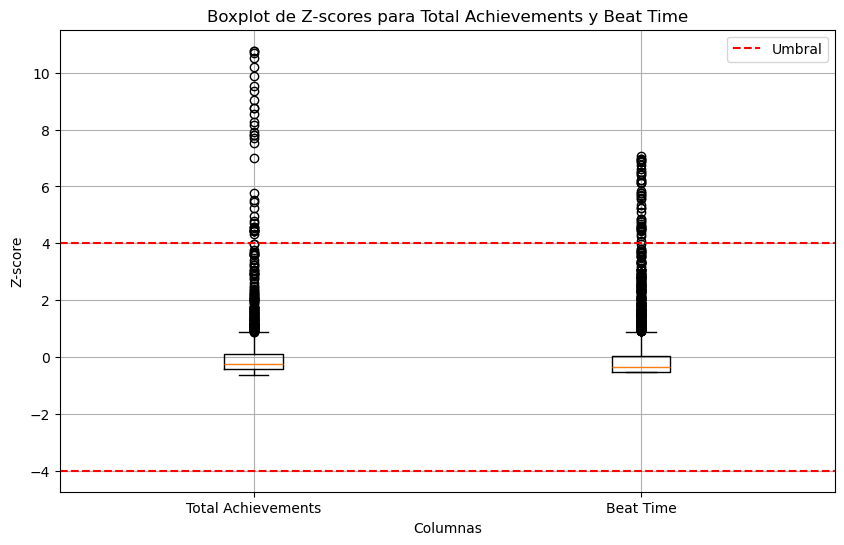

Outliers:
      total_achievements_zscore  beat_time_zscore
438                    0.314039          4.548057
446                    1.297319          6.895930
551                    0.619195          4.548057
586                    3.602941          6.395564
629                    0.619195          4.509567
...                         ...               ...
5550                   9.350043         -0.455608
5557                   4.721846         -0.494098
5650                   8.553247         -0.532587
5913                   7.519108         -0.494098
5935                   0.907397          5.779728

[82 rows x 2 columns]


In [56]:
# Crea el boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([z_scores_achievements, z_scores_beat_time], labels=['Total Achievements', 'Beat Time'])
plt.title('Boxplot de Z-scores para Total Achievements y Beat Time')
plt.xlabel('Columnas')
plt.ylabel('Z-score')
plt.grid(True)
plt.axhline(y=threshold, color='r', linestyle='--', label='Umbral')
plt.axhline(y=-threshold, color='r', linestyle='--')
plt.legend()
plt.show()


print("Outliers:")
print(outliers)

In [57]:
df_games = df_games.drop(outliers.index)

## Normalization

In [58]:
# Suponiendo que df_games['total_achievements'] es tu columna que deseas normalizar
total_achievements = df_games[['total_achievements']].values

# Crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Aplica el escalado Min-Max
df_games['total_achievements'] = scaler.fit_transform(total_achievements)

In [59]:
# Suponiendo que df_games['total_achievements'] es tu columna que deseas normalizar
total_achievements = df_games[['beat_time']].values

# Crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Aplica el escalado Min-Max
df_games['beat_time'] = scaler.fit_transform(total_achievements)

<hr>

## Trainning

In [60]:
features = df_games[['total_achievements', 'achievement_completed', 'playtime_forever']]
target = df_games['beat_time']	


df_games['beat_time'] = pd.to_numeric(df_games['beat_time'], errors='coerce')
df_games['total_achievements'] = pd.to_numeric(df_games['total_achievements'], errors='coerce')

df_games['achievement_completed'] = pd.to_numeric(df_games['achievement_completed'], errors='coerce')
df_games['playtime_forever'] = pd.to_numeric(df_games['playtime_forever'], errors='coerce')

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Inicializa el modelo de regresión lineal
model = LinearRegression()

# Entrena el modelo con los datos de entrenamiento
model.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

In [61]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2859 entries, 0 to 5939
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_achievements     2859 non-null   float64
 1   achievement_completed  2859 non-null   int64  
 2   playtime_forever       2859 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 89.3 KB


<hr>

## Results

In [62]:
# Evalúa el rendimiento del modelo (en este caso, usando el error cuadrático medio)
mse = mean_squared_error(y_test, y_pred)
print(f'Error Cuadrático Medio: {mse}')

Error Cuadrático Medio: 0.021167014555856956


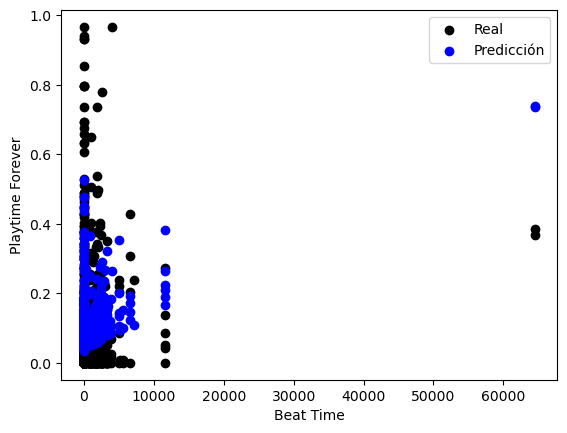

In [63]:
plt.scatter(X_test['playtime_forever'], y_test, color='black', label='Real')
plt.scatter(X_test['playtime_forever'], y_pred, color='blue', label='Predicción')
plt.xlabel('Beat Time')
plt.ylabel('Playtime Forever')
plt.legend()
plt.show()

In [64]:
coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [ 5.12563356e-01 -1.77385372e-03  9.81455319e-06]
Intercept: 0.037025562778906895


In [65]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate metrics using the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.021167014555856956
R-squared: 0.08136159559099809
